In [ ]:
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from skimage.morphology import skeletonize
import math
from skimage.metrics import structural_similarity as ssim

In [ ]:
files = files.upload()

Saving 11.png to 11.png
Saving 12.png to 12.png
Saving 13.png to 13.png
Saving 14.png to 14.png
Saving 15.png to 15.png
Saving 21.png to 21.png
Saving 22.png to 22.png
Saving 23.png to 23.png
Saving 24.png to 24.png
Saving 25.png to 25.png
Saving 31.png to 31.png
Saving 32.png to 32.png
Saving 33.png to 33.png
Saving 34.png to 34.png
Saving 35.png to 35.png
Saving 41.png to 41.png
Saving 42.png to 42.png
Saving 43.png to 43.png
Saving 44.png to 44.png
Saving 45.png to 45.png
Saving 51.png to 51.png
Saving 52.png to 52.png
Saving 53.png to 53.png
Saving 54.png to 54.png
Saving 55.png to 55.png
Saving 61.png to 61.png
Saving 62.png to 62.png
Saving 63.png to 63.png
Saving 64.png to 64.png
Saving 65.png to 65.png
Saving 71.png to 71.png
Saving 72.png to 72.png
Saving 73.png to 73.png
Saving 74.png to 74.png
Saving 75.png to 75.png
Saving 81.png to 81.png
Saving 82.png to 82.png
Saving 83.png to 83.png
Saving 84.png to 84.png
Saving 85.png to 85.png
Saving 91.png to 91.png
Saving 92.png to

# Custom approach

In this approach we follow our custom alghoritm:
1. Read the image and find most outermost points. This together with width and height are our first features we compare
2. Based on the points from above we crop our images to a rectangle so that the signature is fully contained within it. Then we calculate the proportion of black pixels to white pixels. This proportion is our second feature
3. Then we perform skeletization on the image. We use this skeleton to find characteristic points in the picture such as line endings, crosses and forks. We save all these points as our features and then we match them between two pictures to see how many of them actually match
4. We compare all the features we gathered and return a result based on them and on a given threshold

In [ ]:
def top_point(img):
  height, width = img.shape

  for i in range(height):
    for j in range(width):
      if img[i, j] == 0:
        return [i, j]

def bottom_point(img):
  height, width = img.shape

  for i in range(height-1, 0, -1):
    for j in range(width):
      if img[i, j] == 0:
        return [i, j]

def left_point(img):
  height, width = img.shape

  for j in range(width):
    for i in range(height):
      if img[i, j] == 0:
        return [i, j]

def right_point(img):
  height, width = img.shape

  for j in range(width-1, 0, -1):
    for i in range(height):
      if img[i, j] == 0:
        return [i, j]

def black_to_white(img):
  black = 0
  white = 0

  height, width = img.shape

  for i in range(height):
    for j in range(width):
      if img[i, j] == 0:
        black += 1
      else:
        white += 1
  return [black, white]

def get_skeleton_image(threshold_image):
  skeleton = skeletonize(threshold_image / 255)
  skeleton = skeleton.astype(np.uint8)
  skeleton *= 255
  return skeleton

def get_num_of_neighbors(img, x, y, color=255):
  num_of_neighbors = 0
  if img[x-1,y-1] == color:
    num_of_neighbors += 1
  if img[x-1,y] == color:
    num_of_neighbors += 1
  if img[x-1,y+1] == color:
    num_of_neighbors += 1
  if img[x,y-1] == color:
    num_of_neighbors += 1
  if img[x,y+1] == color:
    num_of_neighbors += 1
  if img[x+1,y-1] == color:
    num_of_neighbors += 1
  if img[x+1,y] == color:
    num_of_neighbors += 1
  if img[x+1,y+1] == color:
    num_of_neighbors += 1
  return num_of_neighbors

def detect_features(img):
  height, width = img.shape
  features = []

  for i in range(1, height-1):
    for j in range(1, width-1):
      if img[i,j] == 255:
        num_of_neighbors = get_num_of_neighbors(img, i, j)
        if num_of_neighbors == 1 or num_of_neighbors > 2:
          features.append((i,j))
  return features

def remove_noise(binary_image, kernel_size=3):
  # Create a structuring element for morphological operations
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

  # Perform morphological operations - erosion followed by dilation
  eroded_image = cv2.erode(binary_image, kernel, iterations=1)
  denoised_image = cv2.dilate(eroded_image, kernel, iterations=1)

  return denoised_image

def match_features(features1, features2):
  feat1 = features1.copy()
  feat2 = features2.copy()
  if(len(features1) > len(features2)):
    features1, features2 = features2, features1
  matches = 0

  for feat_index, feature in enumerate(features1):
    min_d = 999999
    min_coords_index = 0
    for index, feature_prim in enumerate(feat2):
      d = math.sqrt((feature[0]-feature_prim[0])**2 + (feature[1]-feature_prim[1])**2)
      if d < min_d:
        min_d = d
        min_coords_index = index
    if min_d < 75:
      feat2.pop(min_coords_index)
      matches += 1

  return matches

In [ ]:
# img1 = cv2.imread('NFI-00101001.png', cv2.IMREAD_GRAYSCALE)
# img2 = cv2.imread('NFI-00102001.png', cv2.IMREAD_GRAYSCALE)
# img3 = cv2.imread('NFI-00201002.png', cv2.IMREAD_GRAYSCALE)


def check_similarity(img1, img2):
  print(f'Checking {img1} against {img2}')
  img1 = cv2.imread(img1, cv2.IMREAD_GRAYSCALE)
  img2 = cv2.imread(img2, cv2.IMREAD_GRAYSCALE)

  img1 = cv2.resize(img1, (1600, 900))
  img2 = cv2.resize(img2, (1600, 900))

  # Binarize the image
  _, img1 = cv2.threshold(img1, 200, 255, cv2.THRESH_BINARY)
  # cv2_imshow(img1)
  _, img2 = cv2.threshold(img2, 200, 255, cv2.THRESH_BINARY)

  [top_point_x, top_point_y] = top_point(img1)
  [bottom_point_x, bottom_point_y] = bottom_point(img1)
  [left_point_x, left_point_y] = left_point(img1)
  [right_point_x, right_point_y] = right_point(img1)

  cropped_img1 = img1[top_point_x:bottom_point_x, left_point_y:right_point_y]
  black1, white1 = black_to_white(cropped_img1)
  cropped_img1 = remove_noise(cropped_img1)

  szerokosc1 = right_point_x - left_point_x
  wysokosc1 = bottom_point_y - top_point_y

  [top_point_x, top_point_y] = top_point(img2)
  [bottom_point_x, bottom_point_y] = bottom_point(img2)
  [left_point_x, left_point_y] = left_point(img2)
  [right_point_x, right_point_y] = right_point(img2)

  cropped_img2 = img2[top_point_x:bottom_point_x, left_point_y:right_point_y]
  black2, white2 = black_to_white(cropped_img2)
  cropped_img2 = remove_noise(cropped_img2)

  szerokosc2 = right_point_x - left_point_x
  wysokosc2 = bottom_point_y - top_point_y

  proportion1 = black1/white1 * 100
  proportion2 = black2/white2 * 100
  if(proportion1 > proportion2):
    minus = proportion1 - proportion2
    if(minus > 3):
      print("Brak zgodności")
      return False
  if(proportion2 > proportion1):
    minus = proportion1 - proportion2
    if(minus > 3):
      print("Brak zgodności")
      return False

  skeleton1 = get_skeleton_image(cv2.bitwise_not(cropped_img1))
  skeleton2 = get_skeleton_image(cv2.bitwise_not(cropped_img2))
  features1 = detect_features(skeleton1)
  features2 = detect_features(skeleton2)
  print("features1", len(features1))
  print("features2", len(features2))

  matches1 = match_features(features1, features2)
  print("matches1", matches1)

  if(len(features1) <= len(features2)):
    percent_result = (matches1/len(features1)) * 100
  if(len(features1) > len(features2)):
    percent_result = (matches1/len(features2)) * 100
  print("similarity: ", percent_result)
  return percent_result > 50

print('Pary niepoprawne')
print(check_similarity('11.png', '21.png'))
print(check_similarity('34.png', '41.png'))
print(check_similarity('52.png', '91.png'))
print(check_similarity('75.png', '85.png'))

print('\nPary poprawne')
print(check_similarity('11.png', '12.png'))
print(check_similarity('32.png', '33.png'))
print(check_similarity('111.png', '112.png'))
print(check_similarity('125.PNG', '125.PNG'))
print(check_similarity('171.PNG', '174.PNG'))

Pary niepoprawne
Checking 11.png against 21.png
Brak zgodności
False
Checking 34.png against 41.png
features1 75
features2 199
matches1 26
similarity:  34.66666666666667
False
Checking 52.png against 91.png
features1 161
features2 331
matches1 59
similarity:  36.64596273291926
False
Checking 75.png against 85.png
features1 234
features2 394
matches1 103
similarity:  44.01709401709402
False

Pary poprawne
Checking 11.png against 12.png
features1 174
features2 153
matches1 153
similarity:  100.0
True
Checking 32.png against 33.png
features1 133
features2 118
matches1 118
similarity:  100.0
True
Checking 111.png against 112.png
features1 444
features2 504
matches1 278
similarity:  62.612612612612615
True
Checking 125.PNG against 125.PNG
features1 167
features2 167
matches1 167
similarity:  100.0
True
Checking 171.PNG against 174.PNG
features1 100
features2 75
matches1 75
similarity:  100.0
True


# Structural similarity

In [ ]:
def compare_signatures_ssim(signature1, signature2, threshold=0.7):
    resized_signature1 = cv2.resize(signature1, (300, 150))
    resized_signature2 = cv2.resize(signature2, (300, 150))

    score = ssim(resized_signature1, resized_signature2)

    if score >= threshold:
        return True
    else:
        return False

img1 = cv2.imread('151.PNG', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('152.PNG', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('63.png', cv2.IMREAD_GRAYSCALE)

print(compare_signatures_ssim(img1, img2))
print(compare_signatures_ssim(img1, img3))


True
False


# SIFT

In [ ]:
def compare_signatures_sift(signature1, signature2):

    sift = cv2.SIFT_create()

    keypoints1, descriptors1 = sift.detectAndCompute(signature1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(signature2, None)

    index_params = dict(algorithm=0, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    similarity_score = len(good_matches)
    if similarity_score >= 20:
        return True
    else:
        return False


img1 = cv2.imread('15.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('13.png', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('155.PNG', cv2.IMREAD_GRAYSCALE)

print(compare_signatures_sift(img1, img2))
print(compare_signatures_sift(img1, img3))


True
False


# Other

Najbardziej lewy punkt to (205, 206)


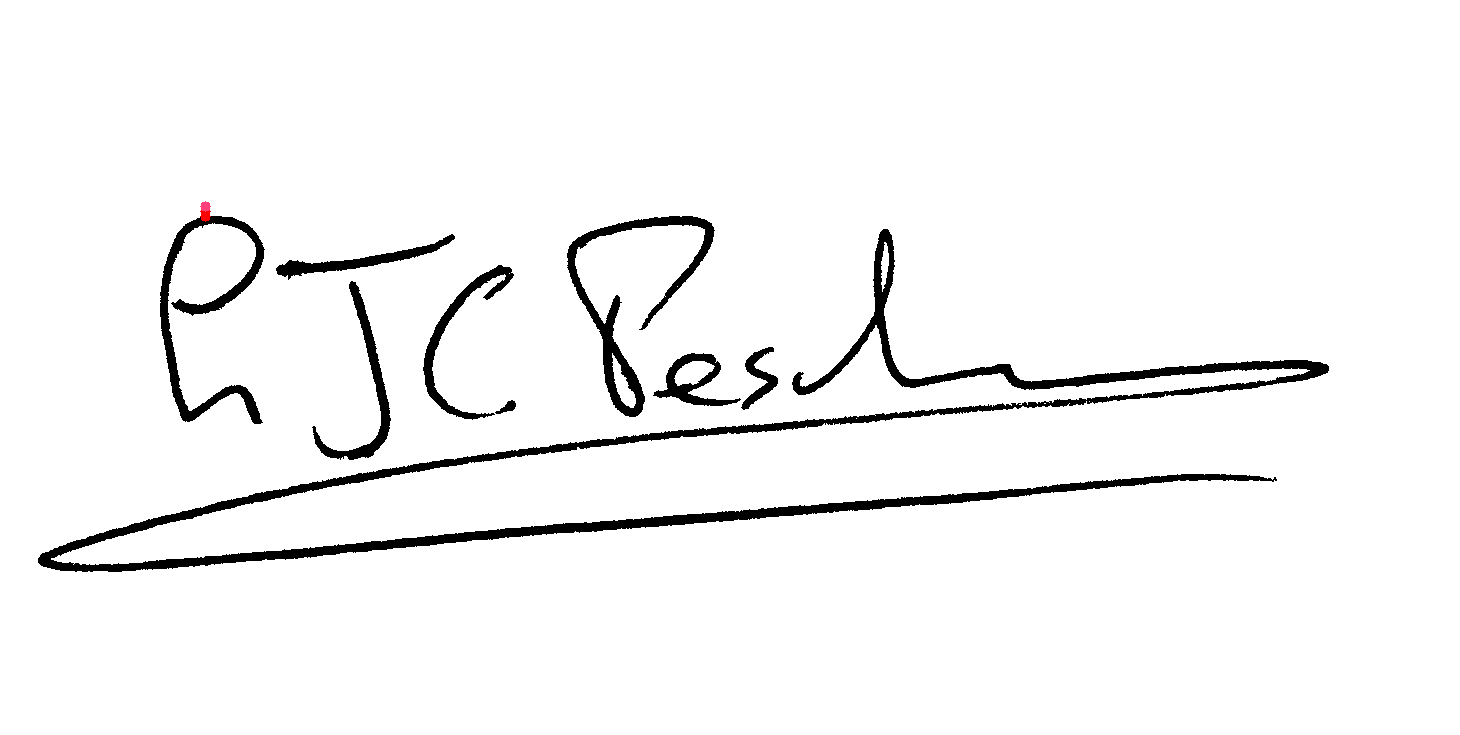

In [ ]:
import numpy as np

# Twój kod wczytujący i pokazujący obraz
_, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
# cv2_imshow(img)

# Wyszukaj najbardziej lewy punkt
height, width, dim = img.shape
for y in range(height):
    for x in range(width):
        if img[y][x][0] == 0:  # jeśli piksel jest biały
            print(f"Najbardziej lewy punkt to ({x}, {y})")
            cv2.circle(img,(x,y),5,(123,64,255),-1)

            break
    else:
        continue
    break

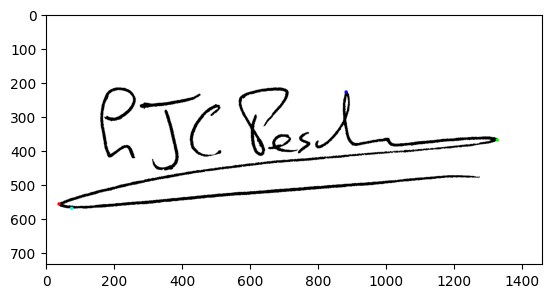

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

img = cv2.imread('NFI-00101001.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
image = cv2.cvtColor(gray, cv2.COLOR_BGR2RGB)
# Binaryzacja obrazu
_, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

# Znajdowanie konturów
contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Możemy założyć, że najdłuższy kontur to nasz podpis
contour = max(contours, key = cv2.contourArea)

# Znajdowanie najbardziej wysuniętych punktów
leftmost = tuple(contour[contour[:,:,0].argmin()][0])
rightmost = tuple(contour[contour[:,:,0].argmax()][0])
topmost = tuple(contour[contour[:,:,1].argmin()][0])
bottommost = tuple(contour[contour[:,:,1].argmax()][0])

# Rysowanie punktów na obrazie
cv2.circle(img, leftmost, 5, (0,0,255), -1)
cv2.circle(img, rightmost, 5, (0,255,0), -1)
cv2.circle(img, topmost, 5, (255,0,0), -1)
cv2.circle(img, bottommost, 5, (255,255,0), -1)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


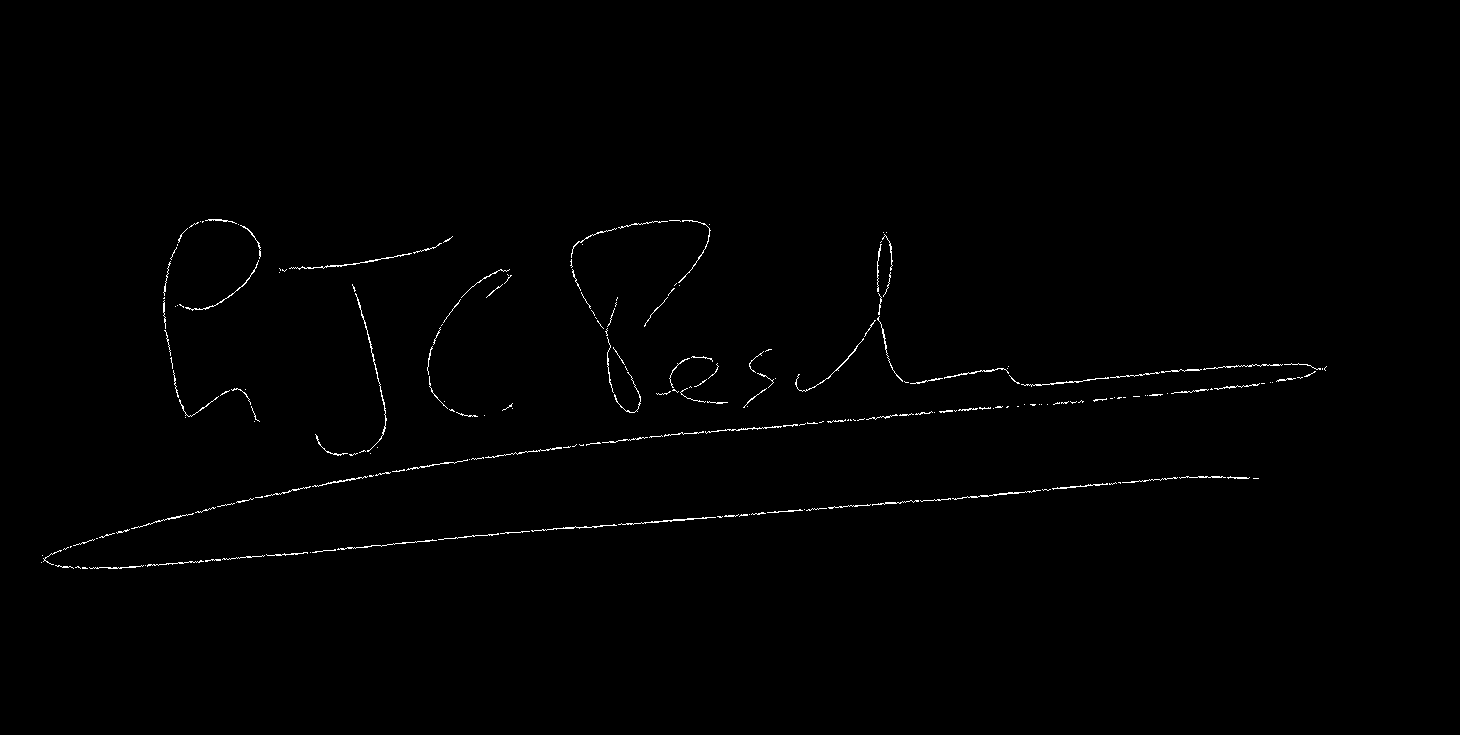

In [ ]:
def find_text_skeleton(image_path):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Binarize the image
    _, thresholded = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)

    # Apply morphological operations to remove noise and smooth the image
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    eroded = cv2.erode(thresholded, kernel, iterations=1)
    opened = cv2.morphologyEx(eroded, cv2.MORPH_OPEN, kernel, iterations=1)

    # Initialize the skeleton image
    skeleton = np.zeros_like(opened)

    # Perform Zhang-Suen thinning algorithm
    while cv2.countNonZero(opened) > 0:
        temp = opened.copy()

        # Step 1
        eroded = cv2.erode(opened, kernel, iterations=1)
        temp = cv2.dilate(eroded, kernel, iterations=1)
        temp = cv2.subtract(opened, temp)
        skeleton = cv2.bitwise_or(skeleton, temp)

        # Step 2
        opened = eroded.copy()

        # Step 3
        eroded = cv2.erode(opened, kernel, iterations=1)
        temp = cv2.dilate(eroded, kernel, iterations=1)
        temp = cv2.subtract(opened, temp)
        skeleton = cv2.bitwise_or(skeleton, temp)

        # Step 4
        opened = eroded.copy()

    return skeleton

skeleton_image = find_text_skeleton('NFI-00101001.png')
cv2_imshow(skeleton_image)
# plt.imshow(skeleton_image)
# plt.show()